# 1. Game Castle

* Movimiento: -1 punto
* Pisar el dragón: -100 puntos
* LLegar al castillo: 100 puntos y termina la partida

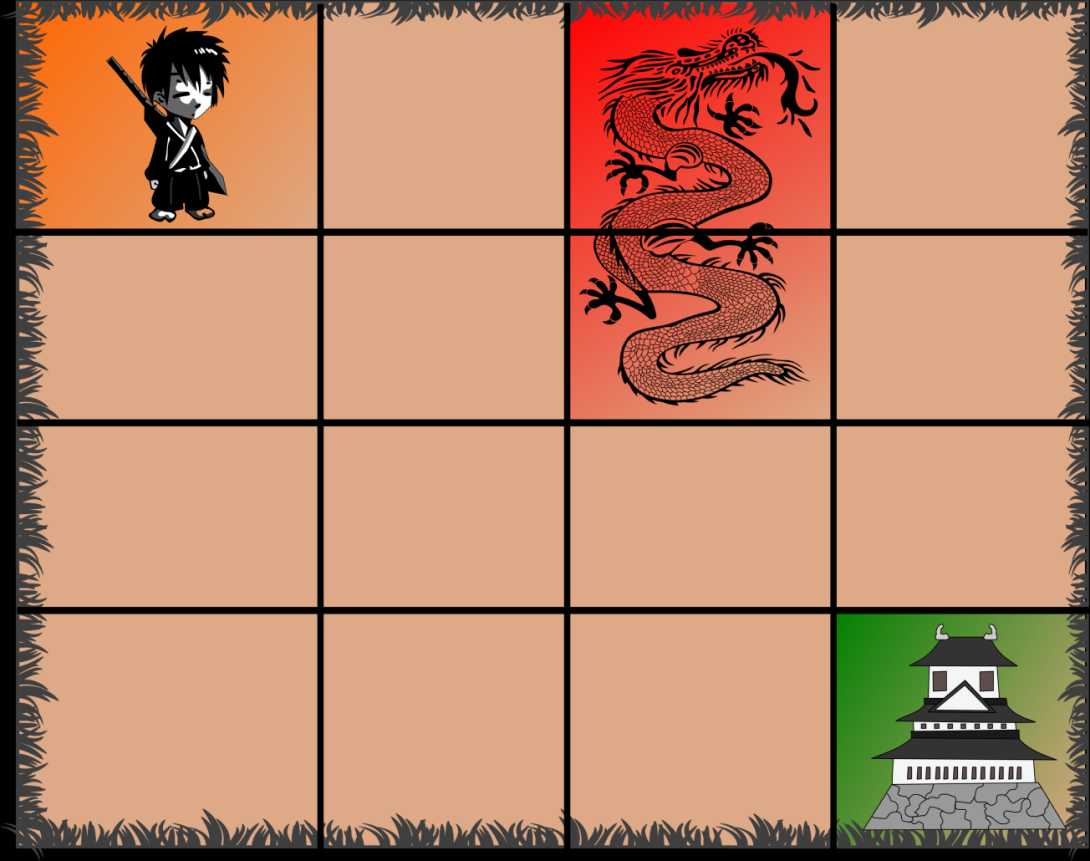

In [1]:
import random as rn
import numpy as np
np.random.seed(42)
rn.seed(12345)

In [2]:
#@title class NinjaCastle()
import numpy as np
# rewards = np.array([[0, 0, -100, 0],
#                          [0, 0, -100, 0],
#                          [0, 0, 0, 0],
#                          [0, 0, 0, 100]])

class NinjaCastle():
    action_space = {
        '👆🏽': np.array([-1, 0]), 
        '👇🏽': np.array([1, 0]),
        '👈': np.array([0, -1]),
        '👉': np.array([0, 1])
    }
    state = np.array([0, 0])  # where is the ninja
    total_reward = 0
    _rewards = np.array([[0, 0, -100, 0],
                         [0, 0, -100, 0],
                         [0, 0, 0, 0],
                         [0, 0, 0, 100]])
    positions_space = _rewards.shape  # inside reward

    _step_penalization = -1
    _final_state = np.array([3, 3])

    def __init__(self,state_as_img=False):
      self.state_as_img=state_as_img

    def make_state(self):
      if self.state_as_img:
        place = self._rewards.astype(str)
        place[self.state[0], self.state[1]] = '1'
        return place
      else:
        return np.copy(self.state)

    def reset(self):
        self.total_reward = 0
        self.state = [0, 0]
        return self.make_state()

    def render(self):
        place = self._rewards.astype(str)
        place[self.state[0], self.state[1]] = '👦'
        print(place)

    def step(self, action):
        self._apply_action(action)
        done = np.array_equal(self.state, self._final_state)  # final
        info = ""
        reward = self._rewards[self.state[0], self.state[1]]
        reward += self._step_penalization
        self.total_reward += reward
        return self.make_state(), reward, done, info

    def _apply_action(self, action):
        self.state += self.action_space[action]
        if self.state[0] > self._rewards.shape[0] - 1:
            self.state[0] = self._rewards.shape[0] - 1
        elif self.state[0] < 0:
            self.state[0] = 0

        if self.state[1] > self._rewards.shape[1] - 1:
            self.state[1] = self._rewards.shape[1] - 1
        elif self.state[1] < 0:
            self.state[1] = 0

nc=NinjaCastle()
action_space = nc.action_space
estado = nc.state
print("Juego:\n",nc._rewards,
      "\n\nAcciones:\n",list(action_space.keys()),
      "\n\nEstado:\n",estado)

Juego:
 [[   0    0 -100    0]
 [   0    0 -100    0]
 [   0    0    0    0]
 [   0    0    0  100]] 

Acciones:
 ['👆🏽', '👇🏽', '👈', '👉'] 

Estado:
 [0 0]


In [3]:
game = NinjaCastle()
game.reset()

array([0, 0])

# 2. Q-Table
Guardamos en una matriz de 4x4x4 la "probabilidad" de ser elegida una acción estando en una fila y columna del tablero de juego.

Valor Q-Table = [fila,columna,acción]

In [4]:
position = list(game.positions_space)
position.append(len(action_space))
q_table = np.zeros(position)
q_table.shape

(4, 4, 4)

In [5]:
#Funciones para pintar bonita la Q-Table
def print_policy_row_column(row_column):
  for value, emo in zip(row_column,["👆🏽","👇🏽","👈","👉"]):
        print(f"{emo}({str(value).zfill(4)})", end=' ')

def print_policy(q_table, precision=1):
  for row in np.round(q_table, precision):
    for row_column in row:
      print('[', end='')
      print_policy_row_column(row_column)
      print('] ', end='')
    print('')

In [6]:
print(game._rewards)
print_policy(q_table)

[[   0    0 -100    0]
 [   0    0 -100    0]
 [   0    0    0    0]
 [   0    0    0  100]]
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 


# 3. Aprendizaje a corto plazo

Se modifican los valores de la Q-Table en función de:
* El valor Q actual para un estado (posición [x,y]) y una acción
* Recompensa obtenida por realizar dicha acción

```
aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)
```


## Ejemplo: **No** ir hacia el dragón cuando estás a un paso

Ponemos al ninja en el punto [0,1], al lado del dragon y lo movemos a la derecha, para que aprenda que no debe ir ahí.

In [7]:
game.reset()
state, _, _, _ = game.step("👉")
game.render()

[['0' '👦' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]


In [8]:
print(f"La q_table para el estado {state} es:")
print_policy_row_column(q_table[state[0],state[1]])

La q_table para el estado [0 1] es:
👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) 

In [9]:
# elegimos ahora la acción de ir a la derecha estando a la izquierda del dragón
accion = "👉"
id_accion = list(game.action_space).index(accion)
print(f"Acción {accion} con id {id_accion}")

Acción 👉 con id 3


In [10]:
state_new, reward, done, info = game.step(accion)
game.render()
print(f"Estado {state}\nAcción [{accion}]\nRecompensa[{reward}]\nNuevo Estado {state_new}")

[['0' '0' '👦' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]
Estado [0 1]
Acción [👉]
Recompensa[-101]
Nuevo Estado [0 2]


¡Catastrofre, ir de [0,1] a [0,2] obtenemos -101 puntos de recompensa!

¿Cómo aprender la lección? 

Modifiando en la q_table la acción de irse a la derecha estando en [0,1]

In [11]:
valor_q_actual = q_table[state[0],state[1],id_accion]
print(f"En estado{state}, q_table tiene valor {valor_q_actual} para la acción {accion}")

En estado[0 1], q_table tiene valor 0.0 para la acción 👉


In [12]:
learning_rate = 0.1

In [13]:
aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)
print(f"El aprendizaje a corto plazo es {aprendizaje_a_corto}")

El aprendizaje a corto plazo es -10.100000000000001


In [14]:
q_table[state[0],state[1],id_accion] = aprendizaje_a_corto
print(game._rewards)
print_policy(q_table)

[[   0    0 -100    0]
 [   0    0 -100    0]
 [   0    0    0    0]
 [   0    0    0  100]]
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(-10.1) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 


##Repitiendo la acción

¿Como varía a lo largo del tiempo la misma acción?

In [15]:
#Función de aprendizaje a corto plazo
def aprendizaje_a_corto_plazo(valor_q_actual, reward):
  aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)
  print(f"{str(round(aprendizaje_a_corto,10)): >19} = {round(valor_q_actual,10): >14} + {learning_rate: >13}*({reward}   - {valor_q_actual})")
  return aprendizaje_a_corto

In [16]:
# Ponemos a 0 la Q-Table
q_table = np.zeros(position)
print_policy(q_table)
print("")
print("aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)")

for _ in range(20):
  # Muevo el juego hasta la posición 0,1
  game.reset()
  state, _, _, _ = game.step("👉")
  state_new, reward, done, info = game.step("👉")

  #actualizamos q_table
  aprendizaje_a_corto = aprendizaje_a_corto_plazo(q_table[state[0],state[1],id_accion],reward)
  q_table[state[0],state[1],id_accion] = aprendizaje_a_corto

  
print("")  
print_policy(q_table)

[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 

aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)
              -10.1 =            0.0 +           0.1*(-101   - 0.0)
             -19.19 =          -10.1 +           0.1*(-101   - -10.100000000000001)
            -27.371 =         -19.19 +           0.1*(-101   - -19.190000000000005)
           -34.7339 =        -27.371 +           0.1*(-101   - -27.371000000000006)
    

En cada iteración, el valor Q se va aproximando al valor de la recompensa para ese estado+acción.
La velocidad con la que se aproxima se puede controlar con el **learning_rate**.

## Ejemplo: **Sí** ir hacia el castillo cuando está cerca del castillo

In [17]:
def mueve_cerca_del_castillo(pasos_derecha=2):
  game.reset()
  for _ in range(3):
    game.step("👇🏽")
  for _ in range(pasos_derecha):
    state_new, reward, done, info = game.step("👉")
  return state_new, reward, done, info

mueve_cerca_del_castillo()
game.render()


[['0' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '👦' '100']]


In [18]:
q_table = np.zeros(position)
print_policy(q_table)
print("")
print("aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)")

for _ in range(30):
  # Muevo el juego hasta la posición 3,3
  state, _, _, _ = mueve_cerca_del_castillo()
  state_new, reward, done, info = game.step("👉")
  id_accion=list(game.action_space).index("👉")

  #actualizamos q_table
  aprendizaje_a_corto = aprendizaje_a_corto_plazo(q_table[state[0],state[1],id_accion],reward)
  q_table[state[0],state[1],id_accion] = aprendizaje_a_corto

  
print("")  
print_policy(q_table)

[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 

aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)
                9.9 =            0.0 +           0.1*(99   - 0.0)
              18.81 =            9.9 +           0.1*(99   - 9.9)
             26.829 =          18.81 +           0.1*(99   - 18.810000000000002)
            34.0461 =         26.829 +           0.1*(99   - 26.829)
           40.54149 =        34.0461 +    

## ¿Y si tengo valores equivocados?

Supongamos que el valor Q para acercarse al castillo es negativo. Si en nuestra optimización, aun así escogemos ir al azar hacia el castillo y conseguimos la recompensa positiva, el algoritmo a corto es capaz de capturar esa mejora

In [19]:
q_table = np.zeros(position)
q_table[3,2,list(game.action_space).index("👉")]=-10
print_policy(q_table)
print("")
print("aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)")

for _ in range(13):
  # Muevo el juego hasta la posición 3,3
  state, _, _, _ = mueve_cerca_del_castillo()
  state_new, reward, done, info = game.step("👉")
  id_accion=list(game.action_space).index("👉")

  #actualizamos q_table
  aprendizaje_a_corto = aprendizaje_a_corto_plazo(q_table[state[0],state[1],id_accion],reward)
  q_table[state[0],state[1],id_accion] = aprendizaje_a_corto

  
print("")  
print_policy(q_table)

[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(-10.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 

aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)
                0.9 =          -10.0 +           0.1*(99   - -10.0)
              10.71 =            0.9 +           0.1*(99   - 0.9000000000000004)
             19.539 =          10.71 +           0.1*(99   - 10.71)
            27.4851 =         19.539 +           0.1*(99   - 19.539)
           34.63659 =        27.4851 

Se ha acercado más rápido al valor ideal, porque al restar (reward - valor_q_actual) había mayor diferencia.


## ¿Y si estoy más lejos del castillo?

Si el ninja está a dos casillas del castillo, la optimziación a corto plazo no funciona, porque sólo utiliza la recompensa inmediata para optimizar la Q-Table.

In [20]:
mueve_cerca_del_castillo(pasos_derecha=1)
game.render()

q_table = np.zeros(position)
print_policy(q_table)

print("")
print("aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)")

for _ in range(13):
  # Muevo el juego hasta la posición 3,1
  state, _, _, _ = mueve_cerca_del_castillo(pasos_derecha=1)
  state_new, reward, done, info = game.step("👉")
  id_accion=list(game.action_space).index("👉")

  #actualizamos q_table
  aprendizaje_a_corto = aprendizaje_a_corto_plazo(q_table[state[0],state[1],id_accion],reward)
  q_table[state[0],state[1],id_accion] = aprendizaje_a_corto

  
print("")  
print_policy(q_table)

[['0' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '👦' '0' '100']]
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 

aprendizaje_a_corto = valor_q_actual + learning_rate*(reward - valor_q_actual)
               -0.1 =            0.0 +           0.1*(-1   - 0.0)
              -0.19 =           -0.1 +           0.1*(-1   - -0.1)
             -0.271 =          -0.19 +           0.1*(-1   - -0.19)
            -0.3439 =         -0.271 +

No hemos podido llegar porque sólo se modifica a corto plazo. El valor negativo viene de la "energía" gastada del ninja.

# 4. Aprendizaje a largo plazo

Se modifican los valores de la Q-Table en función de:
* El valor Q actual para un estado (posición [x,y]) y una acción.
* Máxima recompensa esperada en el siguiente estado si realizo esa acción.


```
opciones_q_futuro = q_table[new_state[0], new_state[1]]
state=[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] state_new=[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(07.0) ]
mejor_opcion_futuro = opciones_q_futuro.max()
aprendizaje_a_largo = valor_q_actual + learning_rate*(discount_factor * mejor_opcion_futuro)
```


In [21]:
def aprendizaje_a_largo_plazo(valor_q_actual, opciones_q_futuro):
  mejor_opcion_futuro = opciones_q_futuro.max()
  aprendizaje_a_largo = valor_q_actual + learning_rate*(discount_factor * mejor_opcion_futuro)
  print(f"{str(round(aprendizaje_a_largo,10)): >19} = {round(valor_q_actual,10): >14} + {learning_rate: >13}*({discount_factor}             * {mejor_opcion_futuro}=Max{opciones_q_futuro})")
  return aprendizaje_a_largo

## Ejemplo: **Sí** ir hacia el castillo cuando está a dos casillas

Colocamos al ninja en la misma posición anterior, a dos casillas del castillo. 

Y generamos un valor positivo al lado del castillo, para que el algoritmo a largo plazo sepa que cerca del castillo es bueno irse hacia el.

In [22]:
discount_factor = 0.9 # bastante alto

mueve_cerca_del_castillo(pasos_derecha=1)
game.render()

q_table = np.zeros(position)
q_table[3,2,list(game.action_space).index("👉")]=7.0 # ponemos un valor futuro válido
print_policy(q_table)

print("")
print("aprendizaje_a_largo = valor_q_actual + learning_rate*(discount_factor * mejor_opcion_futuro)")

for _ in range(30):
  # Muevo el juego hasta la posición 3,1
  state, _, _, _ = mueve_cerca_del_castillo(pasos_derecha=1)
  state_new, reward, done, info = game.step("👉")
  id_accion=list(game.action_space).index("👉")

  #actualizamos q_table
  aprendizaje_a_largo= aprendizaje_a_largo_plazo(q_table[state[0],state[1],id_accion],
                                                 q_table[state_new[0], state_new[1]])
  q_table[state[0],state[1],id_accion] = aprendizaje_a_largo

  
print("")  
print_policy(q_table)

[['0' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '👦' '0' '100']]
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(07.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 

aprendizaje_a_largo = valor_q_actual + learning_rate*(discount_factor * mejor_opcion_futuro)
               0.63 =            0.0 +           0.1*(0.9             * 7.0=Max[0. 0. 0. 7.])
               1.26 =           0.63 +           0.1*(0.9             * 7.0=Max[0. 0. 0. 7.])
               1.89 =           1.26 

Ahora desde [3,1] hay probabilidad de ir a por la casilla [3,2] que nos llevará al castillo en el siguiente movimiento.

## Ejemplo: **No** ir hacia el dragón cuando está a dos casillas
Ponemos al ninja en el punto [0,0], al 2 casillas del dragon y lo movemos a la derecha, para que aprenda encaminarse hacia el dragón no es buena idea.

En este caso, inicializamos los valores de la Q-Table con valores distintos de 0, para que al elegir el valor máximo (discount_factor * mejor_opcion_futuro), tenga algo de efecto.

In [23]:
discount_factor = 0.9 # bastante alto

game.reset() # posición [0,0]
game.render()

q_table = np.zeros(position)+1 #inicializamos con valores positivos para que tenga efecto el max
q_table[0,1,list(game.action_space).index("👉")]=-9.0 # ponemos un valor futuro válido
print_policy(q_table)

print("")
print("aprendizaje_a_largo = valor_q_actual + learning_rate*(discount_factor * mejor_opcion_futuro)")

for _ in range(30):
  # Muevo el juego hasta la posición 0,0
  state= game.reset()
  reward=0
  state_new, reward, done, info = game.step("👉")
  id_accion=list(game.action_space).index("👉")

  #actualizamos q_table
  aprendizaje_a_largo= aprendizaje_a_largo_plazo(q_table[state[0]    ,state[1],id_accion],
                                                 q_table[state_new[0], state_new[1]])
  q_table[state[0],state[1],id_accion] = aprendizaje_a_largo

  
print("")  
print_policy(q_table)

[['👦' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]
[👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(-9.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] 
[👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] 
[👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] 
[👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] [👆🏽(01.0) 👇🏽(01.0) 👈(01.0) 👉(01.0) ] 

aprendizaje_a_largo = valor_q_actual + learning_rate*(discount_factor * mejor_opcion_futuro)
               1.09 =            1.0 +           0.1*(0.9             * 1.0=Max[ 1.  1.  1. -9.])
               1.18 =           1.09 +           0.1*(0.9             * 1.0=Max[ 1.  1.  1. -9.])
               1.27 =        

En este caso, la acción a largo plazo negativa no está contribuyendo a la mejora de la decisión, sino que el aprendizaje se da por los valores positivos pequeños. Si te fijas, no a aumentado mucho la probablidad de [0,0,👉].

# 5. Ecuación de Bellman
\begin{equation}
\underbrace{\text{New}Q(s,a)}_{\scriptstyle\text{New Q-Value}}={Q(s,a)}+\mkern-34mu\underset{\text{Learning Rate}}{\underset{\Bigl|}{\alpha}}\mkern-30mu[\underbrace{R(s,a)}_{\scriptstyle\text{Reward}}+\mkern-30mu\underset{\text{Discount rate}}{\underset{\Biggl|}{\gamma}}\mkern-75mu\overbrace{\max Q'(s',a')}^{\scriptstyle\substack{\text{Maximum predicted reward, given} \\ \text{new state and all possible actions}}}\mkern-45mu-Q(s,a)]
\end{equation}


## Aprendizaje a corto y largo plazo

Usamos la ecuación de Bellman para mezclar el aprendizaje a corto y largo plazo

In [24]:
def aprendizaje_a_corto_y_largo_plazo(valor_q_actual, reward, opciones_q_futuro,silent=False,learning_rate=0.1,discount_factor=0.1):
  mejor_opcion_futuro = opciones_q_futuro.max()
  aprendizaje_a_corto_y_largo = valor_q_actual + learning_rate*(reward - valor_q_actual + (discount_factor * mejor_opcion_futuro))
  if not silent:
    print(f"{str(round(aprendizaje_a_corto_y_largo,10)): >27} = {round(valor_q_actual,10): >14}"
        f" + {learning_rate: >13}*({reward}     - {round(valor_q_actual,10): >14} + ({discount_factor}               * {mejor_opcion_futuro}=Max{opciones_q_futuro}))")
  return aprendizaje_a_corto_y_largo

## Ejemplo: Sí ir hacia el castillo cuando está a dos casillas

El efecto de ir hacia el castillo, se ve reducido por el gasto de moverse la primera vez.

In [25]:
discount_factor = 0.9 # bastante alto

mueve_cerca_del_castillo(pasos_derecha=1)
game.render()

q_table = np.zeros(position)
q_table[3,2,list(game.action_space).index("👉")]=7.0 # ponemos un valor futuro válido
print_policy(q_table)

print("\naprendizaje_a_corto_y_largo = valor_q_actual + learning_rate*(reward - valor_q_actual + (discount_factor * mejor_opcion_futuro))")

for _ in range(30):
  # Muevo el juego hasta la posición 3,1
  state, _, _, _ = mueve_cerca_del_castillo(pasos_derecha=1)
  state_new, reward, done, info = game.step("👉")
  id_accion=list(game.action_space).index("👉")

  #actualizamos q_table
  aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(q_table[state[0]    ,state[1],id_accion],reward,
                                                 q_table[state_new[0], state_new[1]],discount_factor=discount_factor)
  q_table[state[0],state[1],id_accion] = aprendizaje_a_corto_y_largo

  
print("")  
print_policy(q_table)

[['0' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '👦' '0' '100']]
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(07.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 

aprendizaje_a_corto_y_largo = valor_q_actual + learning_rate*(reward - valor_q_actual + (discount_factor * mejor_opcion_futuro))
                       0.53 =            0.0 +           0.1*(-1     -            0.0 + (0.9               * 7.0=Max[0. 0. 0. 7.]))
                      1.007 =           0.53 +           

* Sólo a largo plazo:
```
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(18.9) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(07.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ]
```
* A corto y largo plazo:
```
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(05.1) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(07.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ]
```

# 6. Explorando y Explotando la información

No hay que cononcer todo el tablero para maximizar las recompensas.



In [26]:
# Función que utiliza la politica para jugar
def juega_con_politica(politica,partidas):
  print_policy(politica, precision=5)
  total_reward = 0
  for n_game in range(partidas): # juegos
    state = game.reset()
    print("\n",n_game)
    for _ in range(100): # vueltas
      # take max unless tie, then random
      idx_action = np.random.choice(np.flatnonzero(
          politica[state[0], state[1]] == politica[state[0], state[1]].max()
      ))
      next_step = list(game.action_space)[idx_action]
      print(next_step,end=' ')
      state, reward, done, info = game.step(next_step)
      total_reward+=reward
      if done:
        break;
  print(f"\ntotal_reward: {total_reward}")
  return total_reward

In [27]:
q_table = np.random.rand(*position)
juega_con_politica(q_table,1)

[👆🏽(0.37454) 👇🏽(0.95071) 👈(0.73199) 👉(0.59866) ] [👆🏽(0.15602) 👇🏽(0.15599) 👈(0.05808) 👉(0.86618) ] [👆🏽(0.60112) 👇🏽(0.70807) 👈(0.02058) 👉(0.96991) ] [👆🏽(0.83244) 👇🏽(0.21234) 👈(0.18182) 👉(0.1834) ] 
[👆🏽(0.30424) 👇🏽(0.52476) 👈(0.43195) 👉(0.29123) ] [👆🏽(0.61185) 👇🏽(0.13949) 👈(0.29214) 👉(0.36636) ] [👆🏽(0.45607) 👇🏽(0.78518) 👈(0.19967) 👉(0.51423) ] [👆🏽(0.59241) 👇🏽(0.04645) 👈(0.60754) 👉(0.17052) ] 
[👆🏽(0.06505) 👇🏽(0.94889) 👈(0.96563) 👉(0.8084) ] [👆🏽(0.30461) 👇🏽(0.09767) 👈(0.68423) 👉(0.44015) ] [👆🏽(0.12204) 👇🏽(0.49518) 👈(0.03439) 👉(0.90932) ] [👆🏽(0.25878) 👇🏽(0.66252) 👈(0.31171) 👉(0.52007) ] 
[👆🏽(0.54671) 👇🏽(0.18485) 👈(0.96958) 👉(0.77513) ] [👆🏽(0.9395) 👇🏽(0.89483) 👈(0.5979) 👉(0.92187) ] [👆🏽(0.08849) 👇🏽(0.19598) 👈(0.04523) 👉(0.32533) ] [👆🏽(0.38868) 👇🏽(0.27135) 👈(0.82874) 👉(0.35675) ] 

 0
👇🏽 👇🏽 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 👈 
total_rew

-100

## Escogiendo la acción al azar sin utilizar la Q-Table
La Q-Table sólo la utilizaremos para aprender la política, pero no para tomar acciones durante el aprendizaje.

In [28]:
discount_factor = 0.1
game.reset()
game.render()

q_table = np.zeros(position)
resultados=[]

for n_game in range(100): # juegos
  state = game.reset()
  tot_rew=0
  for _ in range(100): # vueltas
    next_step = np.random.choice(list(game.action_space))
    id_accion=list(game.action_space).index(next_step)
    state_new, reward, done, info = game.step(next_step)
    tot_rew+=reward

    #actualizamos q_table
    aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(
        q_table[state[0],state[1],id_accion],
        reward,
        q_table[state_new[0], state_new[1]],
        silent=True)
    q_table[state[0],state[1],id_accion] = aprendizaje_a_corto_y_largo

    state = state_new
    if done:
      resultados.append(tot_rew)
      print("")
      print_policy(q_table, precision=5)
      break;

print("")  
print_policy(q_table)

[['👦' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]

[👆🏽(-0.58033) 👇🏽(-0.41469) 👈(-0.41549) 👉(-0.3449) ] [👆🏽(-0.2729) 👇🏽(-0.1) 👈(-0.41549) 👉(-47.33385) ] [👆🏽(-34.7339) 👇🏽(-10.1) 👈(-0.47127) 👉(-0.41051) ] [👆🏽(-0.271) 👇🏽(-0.19) 👈(-34.73906) 👉(-0.19) ] 
[👆🏽(-0.19281) 👇🏽(-0.271) 👈(-0.47265) 👉(-0.3449) ] [👆🏽(-0.1919) 👇🏽(-0.1) 👈(-0.1) 👉(-19.19) ] [👆🏽(-19.19442) 👇🏽(00.0) 👈(-0.1) 👉(-0.1) ] [👆🏽(-0.1019) 👇🏽(-0.1) 👈(-10.1) 👉(-0.19) ] 
[👆🏽(-0.2729) 👇🏽(-0.1) 👈(-0.271) 👉(-0.1) ] [👆🏽(00.0) 👇🏽(-0.19) 👈(-0.191) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(09.9) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(-0.1) ] [👆🏽(-0.19) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 

[👆🏽(-0.70582) 👇🏽(-0.66496) 👈(-0.63132) 👉(-0.47218) ] [👆🏽(-0.47512) 👇🏽(-0.34752) 👈(-0.53497) 👉(-52.70457) ] [👆🏽(-41.36462) 👇🏽(-10.1) 👈(-0.57618) 👉(-0.41051) ] [👆🏽(-0.271) 👇🏽(-0.3458) 👈(-34.73906) 👉(-0.19) ] 
[👆🏽(-0.48571) 👇🏽(-0.3449

Al explorar en todos los movimientos, se ven valores buenos incluso encima del dragón.
Jugando con la política, vemos el resultado óptimo.

In [29]:
game.reset()
game.render()
juega_con_politica(q_table,3);

[['👦' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]
[👆🏽(-1.11103) 👇🏽(-1.11031) 👈(-1.11103) 👉(-1.11031) ] [👆🏽(-1.11032) 👇🏽(-1.1026) 👈(-1.11101) 👉(-101.10182) ] [👆🏽(-101.09949) 👇🏽(-101.00926) 👈(-1.11028) 👉(-1.01789) ] [👆🏽(-1.01746) 👇🏽(-0.15686) 👈(-101.09602) 👉(-1.02074) ] 
[👆🏽(-1.11102) 👇🏽(-1.10268) 👈(-1.11031) 👉(-1.10283) ] [👆🏽(-1.11029) 👇🏽(-1.02213) 👈(-1.11031) 👉(-101.0162) ] [👆🏽(-101.09614) 👇🏽(-0.16115) 👈(-1.10242) 👉(-0.14207) ] [👆🏽(-1.02024) 👇🏽(8.69219) 👈(-100.99265) 👉(-0.14897) ] 
[👆🏽(-1.11025) 👇🏽(-1.03859) 👈(-1.10299) 👉(-1.02114) ] [👆🏽(-1.10289) 👇🏽(-0.25184) 👈(-1.10254) 👉(-0.17522) ] [👆🏽(-100.99622) 👇🏽(8.34842) 👈(-1.02288) 👉(8.64024) ] [👆🏽(-0.17458) 👇🏽(98.03992) 👈(-0.18509) 👉(8.22024) ] 
[👆🏽(-1.10245) 👇🏽(-1.03783) 👈(-1.04084) 👉(-0.29744) ] [👆🏽(-1.02367) 👇🏽(-0.28146) 👈(-1.04004) 👉(8.15532) ] [👆🏽(-0.21211) 👇🏽(7.24441) 👈(-0.36362) 👉(96.52188) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 

 0
👉 👇🏽 👇🏽 👉 👉 👇🏽 
 1
👉 👇🏽 👇🏽 👉 👉 👇🏽 
 2
👉 👇🏽 👇🏽 👉 👉 👇🏽 
total_reward:

Sin embargo, si vemos los resultados durante el aprendizaje, ha habido muchos juegos con valores bajos.

(array([-2082, -1885, -1866, -1596, -1387, -1365, -1364, -1347, -1264,
        -1161, -1158, -1134, -1053,  -983,  -963,  -860,  -840,  -839,
         -830,  -794,  -771,  -767,  -765,  -764,  -752,  -740,  -735,
         -724,  -679,  -648,  -647,  -646,  -587,  -572,  -545,  -540,
         -474,  -430,  -427,  -418,  -376,  -354,  -345,  -344,  -327,
         -323,  -318,  -261,  -243,  -238,  -229,  -228,  -227,  -226,
         -222,  -214,  -211,  -139,  -116,   -38,   -37,   -31,   -25,
          -19,   -14,   -12,   -11,   -10,    -6,    52,    78,    81,
           90,    91,    92]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1]))

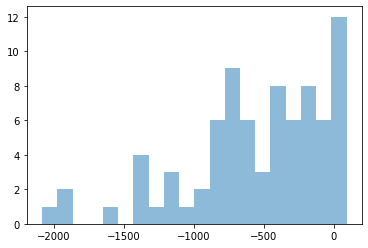

In [30]:
import matplotlib.pyplot as plt

plt.hist(resultados, bins=20, alpha=0.5)
values, counts = np.unique(resultados, return_counts=True)
values, counts

# 7. Explorando y explotando: Algorimto SARS'
Se elije la acción con mayor probabilidad o se explora, en función del parámetro de ratio de exploración.

In [31]:
def sars(ratio_explotacion = 0.95):

  discount_factor = 0.1

  game.reset()
  game.render()

  q_table = np.zeros(position)
  resultados=[]

  for n_game in range(100): # juegos
    state = game.reset()
    tot_rew=0
    for _ in range(100): # vueltas
      next_step = np.random.choice(list(game.action_space))
      if np.random.uniform() <= ratio_explotacion:
        # take max unless tie, then random
        id_accion = np.random.choice(np.flatnonzero(
            q_table[state[0], state[1]] == q_table[state[0], state[1]].max() # AQUI
        ))
        next_step = list(game.action_space)[id_accion]


      id_accion=list(game.action_space).index(next_step)
      state_new, reward, done, info = game.step(next_step)
      tot_rew+=reward

      #actualizamos q_table
      aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(
          valor_q_actual=q_table[state[0],state[1],id_accion],
          reward=reward,
          opciones_q_futuro=q_table[state_new[0], state_new[1]],
          silent=True)
      q_table[state[0],state[1],id_accion] = aprendizaje_a_corto_y_largo

      state = state_new
      if done:
        resultados.append(tot_rew)
        break;

  print("")  
  print_policy(q_table)
  return resultados

[['👦' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]

[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-27.4) ] [👆🏽(-10.1) 👇🏽(-10.1) 👈(-0.2) 👉(-0.2) ] [👆🏽(-0.3) 👇🏽(-0.3) 👈(-10.1) 👉(-0.3) ] 
[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.0) 👇🏽(-1.0) 👈(-1.0) 👉(-27.4) ] [👆🏽(-10.1) 👇🏽(-0.2) 👈(-0.1) 👉(-0.2) ] [👆🏽(-0.2) 👇🏽(00.7) 👈(-10.1) 👉(-0.2) ] 
[👆🏽(-1.0) 👇🏽(-1.0) 👈(-1.0) 👉(-1.0) ] [👆🏽(-0.5) 👇🏽(-0.1) 👈(-0.5) 👉(-0.6) ] [👆🏽(-10.1) 👇🏽(-0.1) 👈(-0.2) 👉(02.7) ] [👆🏽(-0.1) 👇🏽(73.8) 👈(-0.1) 👉(-0.1) ] 
[👆🏽(-0.5) 👇🏽(-0.5) 👈(-0.5) 👉(-0.2) ] [👆🏽(-0.1) 👇🏽(-0.1) 👈(-0.2) 👉(08.9) ] [👆🏽(-0.3) 👇🏽(00.0) 👈(-0.1) 👉(99.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 


valores:[-418 -132  -65  -27  -15   -6   60   68   73   74   75   76   77   80
   81   82   83   84   85   86   87   89   90   91   92   93   94]
Cuenta:[ 1  1  1  1  1  2  1  1  2  1  3  1  1  2  1  2  2  3  3  6  5  5  7 11
 13  8 15]


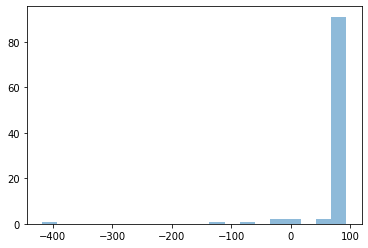

In [32]:
resultados=sars()
plt.hist(resultados, bins=20, alpha=0.5)
values, counts = np.unique(resultados, return_counts=True)
print(f"\n\nvalores:{values}\nCuenta:{counts}")

Hay mayor volumen de partidas durante el aprendizaje que generan valores altos.

## Efecto ratio explotación

¿Cúal es el ratio de explotación óptimo? Dependerá del problema, pero mejor si es alto.

In [33]:
import pandas as pd

df = pd.DataFrame([],columns=["ratio","reward"])
for rat_exp in np.arange(0.0,1.0,0.05):
  resultados=sars(rat_exp)
  df = df.append(
      pd.DataFrame(zip([rat_exp]*len(resultados),resultados),
                   columns=["ratio","reward"])
      )


[['👦' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]

[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-101.1) ] [👆🏽(-101.1) 👇🏽(-101.0) 👈(-1.1) 👉(-1.0) ] [👆🏽(-1.0) 👇🏽(-0.2) 👈(-101.1) 👉(-1.0) ] 
[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.1) 👇🏽(-1.0) 👈(-1.1) 👉(-101.0) ] [👆🏽(-101.1) 👇🏽(-0.2) 👈(-1.1) 👉(-0.2) ] [👆🏽(-1.0) 👇🏽(08.3) 👈(-100.6) 👉(-0.3) ] 
[👆🏽(-1.1) 👇🏽(-1.0) 👈(-1.1) 👉(-1.0) ] [👆🏽(-1.1) 👇🏽(-0.2) 👈(-1.1) 👉(-0.2) ] [👆🏽(-100.6) 👇🏽(08.6) 👈(-1.0) 👉(08.4) ] [👆🏽(-0.3) 👇🏽(97.4) 👈(-0.2) 👉(07.1) ] 
[👆🏽(-1.1) 👇🏽(-1.0) 👈(-1.0) 👉(-0.2) ] [👆🏽(-1.0) 👇🏽(-0.2) 👈(-1.0) 👉(08.5) ] [👆🏽(-0.2) 👇🏽(08.2) 👈(-0.2) 👉(97.9) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[['👦' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]

[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-101.1) ] [👆🏽(-100.6) 👇🏽(-100.3) 👈(-1.1) 👉(-1.0) ] [👆🏽(-1.0) 👇🏽(-0.2) 👈(-100.2) 👉(-1.0) ] 
[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.1) 👇🏽(-1.0) 👈(-

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Resutado')

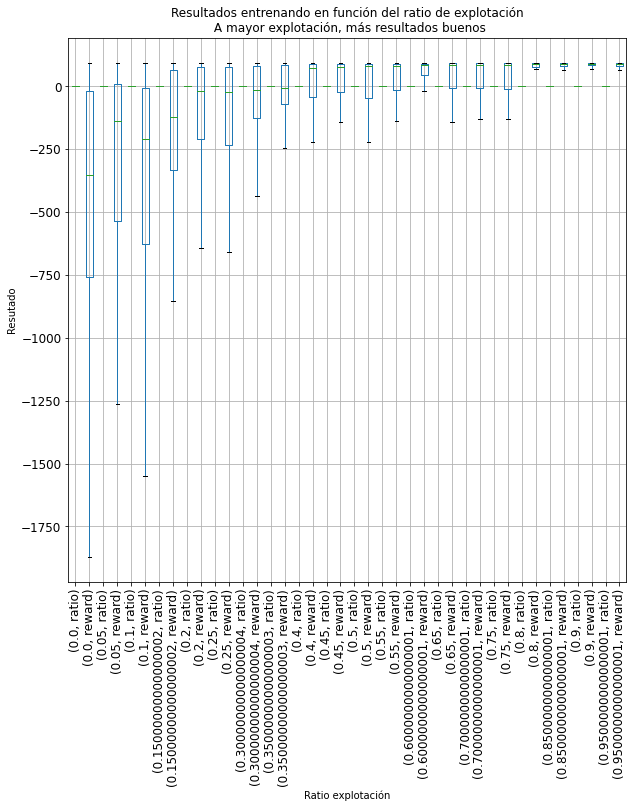

In [34]:
df.reward=df.reward.astype(int)
ax = df.groupby("ratio").boxplot(
    subplots=False, 
    rot=90, 
    fontsize=12,
    figsize=(10,10),
    showfliers=False)
plt.title( "Resultados entrenando en función del ratio de explotación\n A mayor explotación, más resultados buenos" )
ax.set_xlabel("Ratio explotación")
ax.set_ylabel("Resutado")

# 8. Algorimto SARS'A'
Utilizamos la información de la siguiente acción elegible

In [35]:
#@title SARS'A'
def aprendizaje_a_corto_y_largo_plazo_sarsa(valor_q_actual, reward, opciones_q_futuro, idx_accion_tomada,silent=False,learning_rate=0.1,discount_factor=0.1):
  # mejor_opcion_futuro = opciones_q_futuro.max() #sars
  opcion_futura_tomada = opciones_q_futuro[idx_accion_tomada]
  aprendizaje_a_corto_y_largo = valor_q_actual + learning_rate*(reward - valor_q_actual + (discount_factor * opcion_futura_tomada))
  if not silent:
    print(f"{str(round(aprendizaje_a_corto_y_largo,10)): >27} = {round(valor_q_actual,10): >14}"
        f" + {learning_rate: >13}*({reward}     - {round(valor_q_actual,10): >14} + ({discount_factor}               * {opcion_futura_tomada: > 4}=[{idx_accion_tomada}] de {opciones_q_futuro}))")
  return aprendizaje_a_corto_y_largo

def get_next_step(game,q_table,state,ratio_explotacion):
  candidate_next_step = np.random.choice(list(game.action_space))
  id_accion=list(game.action_space).index(candidate_next_step)
  if np.random.uniform() <= ratio_explotacion:
    # take max unless tie, then random
    id_accion = np.random.choice(np.flatnonzero(
        q_table[state[0], state[1]] == q_table[state[0], state[1]].max() 
    ))
    candidate_next_step = list(game.action_space)[id_accion]
  return candidate_next_step, id_accion


def sarsa(ratio_explotacion = 0.95):

  discount_factor = 0.1

  game.reset()
  game.render()

  q_table = np.zeros(position)
  resultados=[]

  for n_game in range(100): # juegos
    state = game.reset()
    tot_rew=0
    for _ in range(100): # vueltas
      next_step, id_accion = get_next_step(game,q_table,state,ratio_explotacion)
      state_new, reward, done, info = game.step(next_step)
      tot_rew+=reward

      #SARSA
      next_post_action,_ = get_next_step(game,q_table,state_new,ratio_explotacion)
      # print(f"a{next_step} a'{next_post_action}")

      #actualizamos q_table
      aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo_sarsa(
          valor_q_actual=q_table[state[0],state[1],id_accion],
          reward=reward,
          opciones_q_futuro=q_table[state_new[0], state_new[1]],
          idx_accion_tomada=list(game.action_space).index(next_post_action), #SARSA
          silent=True)
      q_table[state[0],state[1],id_accion] = aprendizaje_a_corto_y_largo

      state = state_new
      if done:
        resultados.append(tot_rew)
        break;

  print("")  
  print_policy(q_table)
  return resultados

[['👦' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]

[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-10.1) ] [👆🏽(-10.1) 👇🏽(-10.1) 👈(-0.1) 👉(00.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.0) 👇🏽(-1.0) 👈(-1.0) 👉(-19.2) ] [👆🏽(-10.1) 👇🏽(-0.2) 👈(-0.1) 👉(-0.1) ] [👆🏽(00.0) 👇🏽(-0.1) 👈(-10.1) 👉(00.0) ] 
[👆🏽(-1.0) 👇🏽(-1.0) 👈(-1.0) 👉(-1.0) ] [👆🏽(-0.6) 👇🏽(-0.2) 👈(-0.6) 👉(-0.6) ] [👆🏽(-10.1) 👇🏽(06.7) 👈(-0.1) 👉(-0.1) ] [👆🏽(-0.1) 👇🏽(00.0) 👈(-0.1) 👉(00.0) ] 
[👆🏽(-0.5) 👇🏽(-0.6) 👈(-0.5) 👉(-0.2) ] [👆🏽(-0.4) 👇🏽(-0.2) 👈(-0.1) 👉(08.9) ] [👆🏽(-0.2) 👇🏽(00.6) 👈(-0.1) 👉(99.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 


valores:[-371 -310   49   65   72   73   74   78   80   81   83   84   85   86
   87   88   89   90   91   92   93   94]
Cuenta:[ 1  1  1  1  1  1  2  2  2  4  4  6  3  3  3  3  4  7 13 11  3 24]


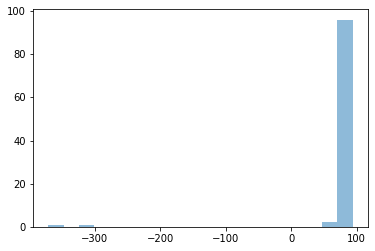

In [36]:
resultados=sarsa()
plt.hist(resultados, bins=20, alpha=0.5)
values, counts = np.unique(resultados, return_counts=True)
print(f"\n\nvalores:{values}\nCuenta:{counts}")

# 9. Redes Neuronales
Vamos a sustituir la q_table por una red neuronal.

En vez de 

estado[0,1]=> Q-Table 
```
[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-34.7) ] [👆🏽(-19.2) 👇🏽(-10.1) 👈(-0.2) 👉(-0.3) ] [👆🏽(-0.2) 👇🏽(-0.3) 👈(-10.1) 👉(-0.2) ] 
[👆🏽(-1.1) 👇🏽(-1.1) 👈(-1.1) 👉(-1.1) ] [👆🏽(-1.0) 👇🏽(-1.0) 👈(-1.0) 👉(-19.2) ] [👆🏽(-10.1) 👇🏽(-0.1) 👈(-0.2) 👉(-0.1) ] [👆🏽(-0.1) 👇🏽(00.3) 👈(-10.1) 👉(-0.2) ] 
[👆🏽(-1.0) 👇🏽(-1.0) 👈(-1.0) 👉(-1.0) ] [👆🏽(-0.7) 👇🏽(-0.1) 👈(-0.6) 👉(-0.6) ] [👆🏽(-10.1) 👇🏽(-0.2) 👈(-0.1) 👉(02.4) ] [👆🏽(00.0) 👇🏽(71.0) 👈(-0.1) 👉(00.3) ] 
[👆🏽(-0.5) 👇🏽(-0.5) 👈(-0.5) 👉(-0.2) ] [👆🏽(-0.3) 👇🏽(-0.2) 👈(-0.1) 👉(08.9) ] [👆🏽(-0.2) 👇🏽(00.8) 👈(-0.1) 👉(99.0) ] [👆🏽(00.0) 👇🏽(00.0) 👈(00.0) 👉(00.0) ] 
```
 => accion[👆🏽(-0.2) 👇🏽(00.8) 👈(-0.1) 👉(99.0) ] 


 Usaremos

estado[0,1]=> NN => accion[👆🏽(-0.2) 👇🏽(00.8) 👈(-0.1) 👉(99.0) ] 

La red neuronal toma el estado del juego (en nuestro caso posición en filas y columnas) y predice 4 valores, uno por acción posible.

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
def create_dense_NN(state_shape,action_size):
  model_learning_rate = 0.1
  model = Sequential()
  model.add(Dense(4, input_shape=state_shape, activation='linear', use_bias=True))
  model.add(Dense(action_size, activation='softmax', use_bias=True))
  model.compile(loss='mse',optimizer="sgd")
  print(model.summary())
  return model

In [38]:
state=game.reset()
model=create_dense_NN(np.shape(state),4)
model.get_weights()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


[array([[ 0.45786166, -0.02472401,  0.29436445,  0.809731  ],
        [ 0.8626754 ,  0.30284047, -0.9425607 , -0.5031071 ]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([[-0.13353312,  0.44513077, -0.56428903, -0.01306462],
        [ 0.38281208, -0.5353753 , -0.8109162 , -0.09763968],
        [ 0.09104377, -0.79570276,  0.10950339,  0.7527786 ],
        [-0.18681645, -0.34209365,  0.16814536,  0.36266655]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32)]

In [39]:
# Es sólo una predicción, el estado 1 va dentro de una lista
datos_entrada= np.expand_dims(np.asarray(state).astype(np.float64), axis=0)
datos_entrada

array([[0., 0.]])

In [40]:
#Obtenemos las acciones posibles de ese estado
opciones_q_futuro = model.predict(datos_entrada)
print(opciones_q_futuro) # una predicción de varias posibles, por eso va en una lista
print_policy_row_column(opciones_q_futuro[0])

[[0.25 0.25 0.25 0.25]]
👆🏽(0.25) 👇🏽(0.25) 👈(0.25) 👉(0.25) 

## Pintar la Q-Table con una Red Neuronal

Se puede pasar por todas las posiciones y pintar la predicción de la NN para las acciones posibles.


In [41]:
def print_NN_policy(model, precision=1):
  q_table_NN = np.zeros(position)
  for row in range(4):
    for col in range(4):
      datos_entrada= np.expand_dims(np.asarray([row,col]).astype(np.float64), axis=0)
      q_table_NN[row,col]=model.predict(datos_entrada)[0]

  print_policy(q_table_NN, precision=precision)

print("Partiendo de estos pesos:\n", model.get_weights())
print_NN_policy(model)


Partiendo de estos pesos:
 [array([[ 0.45786166, -0.02472401,  0.29436445,  0.809731  ],
       [ 0.8626754 ,  0.30284047, -0.9425607 , -0.5031071 ]],
      dtype=float32), array([0., 0., 0., 0.], dtype=float32), array([[-0.13353312,  0.44513077, -0.56428903, -0.01306462],
       [ 0.38281208, -0.5353753 , -0.8109162 , -0.09763968],
       [ 0.09104377, -0.79570276,  0.10950339,  0.7527786 ],
       [-0.18681645, -0.34209365,  0.16814536,  0.36266655]],
      dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
[👆🏽(00.2) 👇🏽(00.2) 👈(00.2) 👉(00.2) ] [👆🏽(00.2) 👇🏽(00.6) 👈(00.1) 👉(00.1) ] [👆🏽(00.1) 👇🏽(00.9) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(01.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.2) 👇🏽(00.2) 👈(00.2) 👉(00.4) ] [👆🏽(00.2) 👇🏽(00.6) 👈(00.1) 👉(00.2) ] [👆🏽(00.1) 👇🏽(00.9) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(01.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.1) 👇🏽(00.1) 👈(00.2) 👉(00.6) ] [👆🏽(00.2) 👇🏽(00.5) 👈(00.1) 👉(00.3) ] [👆🏽(00.1) 👇🏽(00.8) 👈(00.0) 👉(00.1) ] [👆🏽(00.0) 👇🏽(00.9) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.1) 👇🏽(00.1) 👈(00.1) 👉(00.7

## Sustituir la Q-Table por NN

En SARS', hacíamos
```
aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(
          valor_q_actual=q_table[state[0],state[1],id_accion],
          reward=reward,
          opciones_q_futuro=q_table[state_new[0], state_new[1]])
```


Hay que sutituir la Q-Table por las predicciones de la red neuronal
```
aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(
          valor_q_actual=model.predict(state)[0][id_accion],
          reward=reward,
          opciones_q_futuro=model.predict(state_new)[0])
```



### Con la Q-Table, el aprendizaje se sacaba con la ecuación de Bellman

In [42]:
# Aprendizaje con Q-Table
valor_q_actual=q_table[state[0],state[1],id_accion]
opciones_q_futuro=q_table[state_new[0], state_new[1]]
aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(
          valor_q_actual=valor_q_actual,
          reward=reward,
          opciones_q_futuro=opciones_q_futuro,
          silent=True)
print(f"valor_q_actual:{valor_q_actual}\nopciones_q_futuro:{opciones_q_futuro}\naprendizaje_a_corto_y_largo:{aprendizaje_a_corto_y_largo}")

valor_q_actual:-1.1103050165838024
opciones_q_futuro:[0. 0. 0. 0.]
aprendizaje_a_corto_y_largo:8.90072548507458


### Con la NN, también se aplica la ecuación de Bellman

#### Valor Q de estado actual: Q(s,a)<= model.predict(state)

In [43]:
# Las opciones actuales con una NN: predict
datos_entrada= np.expand_dims(np.asarray(state).astype(np.float64), axis=0)
opciones_q_actual = model.predict(datos_entrada)
opciones_q_actual

array([[0.25, 0.25, 0.25, 0.25]], dtype=float32)

#### Elegir siguiente acción: Máximo de las opciones actuales

In [44]:
# take max unless tie, then random
id_accion = np.random.choice(np.flatnonzero(
    opciones_q_actual[0] == opciones_q_actual[0].max() # AQUI
))
next_step = list(game.action_space)[id_accion]
next_step

'👉'

#### Valor Q actual
Igual que en Q-Table

In [45]:
valor_q_actual=opciones_q_actual[0][id_accion]
valor_q_actual

0.25

#### Opciones de futuro
Hay que dar un paso en el juego y hacer un predict del nuevo estado

In [46]:
state_new, reward, done, info = game.step(next_step)
state_new, reward, done, info

(array([0, 1]), -1, False, '')

In [47]:
datos_entrada_new= np.expand_dims(np.asarray(state_new).astype(np.float64), axis=0)
opciones_q_futuro = model.predict(datos_entrada_new)
opciones_q_futuro

array([[0.20423827, 0.63546413, 0.08065594, 0.07964172]], dtype=float32)

#### Aprendizaje con una NN
Se utiliza la misma función que con Q-Table, ya que la información utilizada ya no depende de la NN.

In [48]:
aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(
          valor_q_actual=valor_q_actual,
          reward=reward,
          opciones_q_futuro=opciones_q_futuro,
          silent=False)
print(f"valor_q_actual:{valor_q_actual}\nopciones_q_futuro:{opciones_q_futuro}\naprendizaje_a_corto_y_largo:{aprendizaje_a_corto_y_largo}")

               0.1313546413 =           0.25 +           0.1*(-1     -           0.25 + (0.1               * 0.6354641318321228=Max[[0.20423827 0.63546413 0.08065594 0.07964172]]))
valor_q_actual:0.25
opciones_q_futuro:[[0.20423827 0.63546413 0.08065594 0.07964172]]
aprendizaje_a_corto_y_largo:0.1313546413183212


Y para incluirlo en nuestra Q-Table antes hacíamos 
```
q_table[state[0],state[1],id_accion] = aprendizaje_a_corto_y_largo
```

ahora hay que entrenar la red neuronal para que se parezca al valor que hemos obtenido
```
model.fit(datos_entrada, opciones_q_actual_modificado, epochs=1, verbose=0)
```

In [49]:
print("Valor inicial:")
print_policy_row_column(opciones_q_actual[0])
opciones_q_actual[0][id_accion] =aprendizaje_a_corto_y_largo

print("\nUna vez aprendido lo que queremos que devuelva la NN: ")
print_policy_row_column(opciones_q_actual[0])

Valor inicial:
👆🏽(0.25) 👇🏽(0.25) 👈(0.25) 👉(0.25) 
Una vez aprendido lo que queremos que devuelva la NN: 
👆🏽(0.25) 👇🏽(0.25) 👈(0.25) 👉(0.13135464) 

In [50]:
#Enseñamos a la NN lo que queremos que aprenda con el estado actual
model.fit(datos_entrada, opciones_q_actual, epochs=1, verbose=0)

In [51]:
opciones_q_actual = model.predict(datos_entrada)
print("La nueva prediccion de la red neuronal:")
print_policy_row_column(opciones_q_actual[0])


La nueva prediccion de la red neuronal:
👆🏽(0.25000656) 👇🏽(0.25003663) 👈(0.25000957) 👉(0.24994731) 

In [52]:
print_NN_policy(model)

[👆🏽(00.3) 👇🏽(00.3) 👈(00.3) 👉(00.2) ] [👆🏽(00.2) 👇🏽(00.6) 👈(00.1) 👉(00.1) ] [👆🏽(00.1) 👇🏽(00.9) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(01.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.2) 👇🏽(00.2) 👈(00.2) 👉(00.4) ] [👆🏽(00.2) 👇🏽(00.6) 👈(00.1) 👉(00.2) ] [👆🏽(00.1) 👇🏽(00.9) 👈(00.0) 👉(00.0) ] [👆🏽(00.0) 👇🏽(01.0) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.1) 👇🏽(00.1) 👈(00.2) 👉(00.6) ] [👆🏽(00.2) 👇🏽(00.5) 👈(00.1) 👉(00.3) ] [👆🏽(00.1) 👇🏽(00.8) 👈(00.0) 👉(00.1) ] [👆🏽(00.0) 👇🏽(00.9) 👈(00.0) 👉(00.0) ] 
[👆🏽(00.1) 👇🏽(00.1) 👈(00.1) 👉(00.7) ] [👆🏽(00.1) 👇🏽(00.3) 👈(00.1) 👉(00.5) ] [👆🏽(00.1) 👇🏽(00.7) 👈(00.0) 👉(00.1) ] [👆🏽(00.0) 👇🏽(00.9) 👈(00.0) 👉(00.0) ] 


## SARS con NN

In [53]:
def sars_NN(ratio_explotacion = 0.75):

  discount_factor = 0.6

  state = game.reset()
  game.render()
  ##################################################################
  ## Cambio
  # q_table = np.zeros(position)
  model=create_dense_NN(np.shape(state),4)
  ##################################################################

  resultados=[]


  for n_game in range(60): # juegos
    state = game.reset()
    tot_rew=0
    print(n_game)
    print_NN_policy(model, precision=3)
    # print(model.get_weights())
    for _ in range(150): # vueltas
      next_step = np.random.choice(list(game.action_space))
      ##################################################################
      ## Cambio
      datos_entrada= np.expand_dims(np.asarray(state).astype(np.float64), axis=0)
      opciones_q_actual = model.predict(datos_entrada)
      ##################################################################
      
      if np.random.uniform() <= ratio_explotacion:
        ##################################################################
        ## Cambio
        # take max unless tie, then random
        # id_accion = np.random.choice(np.flatnonzero(
        #     q_table[state[0], state[1]] == q_table[state[0], state[1]].max() # AQUI
        # ))

        id_accion = np.random.choice(np.flatnonzero(
            opciones_q_actual[0] == opciones_q_actual[0].max() # AQUI
        ))
        ##################################################################
        next_step = list(game.action_space)[id_accion]


      id_accion=list(game.action_space).index(next_step)
      state_new, reward, done, info = game.step(next_step)
      tot_rew+=reward


      ##################################################################
      ## Cambio
      #actualizamos q_table
      # aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(
      #     valor_q_actual=q_table[state[0],state[1],id_accion],
      #     reward=reward,
      #     opciones_q_futuro=q_table[state_new[0], state_new[1]],
      #     silent=True)
      # q_table[state[0],state[1],id_accion] = aprendizaje_a_corto_y_largo
      valor_q_actual=opciones_q_actual[0][id_accion]
      datos_entrada_new= np.expand_dims(np.asarray(state_new).astype(np.float64), axis=0)
      opciones_q_futuro = model.predict(datos_entrada_new)
      aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(
          valor_q_actual=valor_q_actual,
          reward=reward,
          opciones_q_futuro=opciones_q_futuro,
          silent=True, learning_rate=0.5,discount_factor=discount_factor)
      opciones_q_actual[0][id_accion] =aprendizaje_a_corto_y_largo
      model.fit(datos_entrada, opciones_q_actual, epochs=1, verbose=0)
      ##################################################################

      state = state_new
      if done:
        print(f"tot_rew:{tot_rew}")
        resultados.append(tot_rew)
        break;

  print("")  
  print_NN_policy(model)
  return resultados

In [54]:
sars_NN(0.3)

[['👦' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 12        
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None
0
[👆🏽(0.25) 👇🏽(0.25) 👈(0.25) 👉(0.25) ] [👆🏽(0.539) 👇🏽(0.093) 👈(0.052) 👉(0.316) ] [👆🏽(0.723) 👇🏽(0.022) 👈(0.007) 👉(0.248) ] [👆🏽(0.828) 👇🏽(0.004) 👈(0.001) 👉(0.167) ] 
[👆🏽(0.193) 👇🏽(0.287) 👈(0.27) 👉(0.249) ] [👆🏽(0.466) 👇🏽(0.119) 👈(0.063) 👉(0.352) ] [👆🏽(0.667) 👇🏽(0.03) 👈(0.009) 👉(0.295) ] [👆🏽(0.788) 👇🏽(0.006) 👈(0.001) 👉(0.205) ] 
[👆🏽(0.146) 👇🏽(0.323) 👈(0.287) 👉(0.244)

[-729,
 -527,
 -250,
 78,
 -636,
 -433,
 26,
 -23,
 -114,
 -1795,
 -634,
 -57,
 -425,
 -109,
 -693,
 81,
 -21,
 -2125,
 -26,
 86,
 -231,
 -328,
 -14,
 90,
 -111,
 -884,
 -21,
 -21,
 91,
 -1175,
 93,
 -858,
 64,
 -1638,
 -16,
 -11,
 -1271,
 -539,
 61,
 90,
 -10,
 -163,
 -217,
 -153,
 79,
 -227,
 84,
 -1287,
 75,
 86,
 -130,
 -1411,
 -230,
 66,
 85,
 91,
 84,
 -557,
 84]

En función de los parámetros iniciales, puede no dar tiempo a optimizar la Q-Table.

Relanzar si fuera así.

# Reducir la exploración con SARS

In [55]:
def sars_NN_decay(ratio_explotacion_max = 0.75,ratio_explotacion_min = 0.25):

  discount_factor = 0.6

  state = game.reset()
  game.render()

  model=create_dense_NN(np.shape(state),4)

  resultados=[]

  n_juegos = 60
  ratio_explotacion=ratio_explotacion_min

  for n_game in range(n_juegos): # juegos
    ##################################################################
    # Cambiar la explotacion
    if ratio_explotacion < ratio_explotacion_max:
        ratio_explotacion+=(ratio_explotacion_max-ratio_explotacion_min)/n_juegos
    print(f"ratio_explotacion:{ratio_explotacion}")
    ##################################################################

    state = game.reset()
    tot_rew=0
    print(n_game)
    print_NN_policy(model, precision=3)
    for _ in range(150): # vueltas
      next_step = np.random.choice(list(game.action_space))
      datos_entrada= np.expand_dims(np.asarray(state).astype(np.float64), axis=0)
      opciones_q_actual = model.predict(datos_entrada)
      
      if np.random.uniform() <= ratio_explotacion:
        id_accion = np.random.choice(np.flatnonzero(
            opciones_q_actual[0] == opciones_q_actual[0].max() # AQUI
        ))
        next_step = list(game.action_space)[id_accion]


      id_accion=list(game.action_space).index(next_step)
      state_new, reward, done, info = game.step(next_step)
      tot_rew+=reward

      valor_q_actual=opciones_q_actual[0][id_accion]
      datos_entrada_new= np.expand_dims(np.asarray(state_new).astype(np.float64), axis=0)
      opciones_q_futuro = model.predict(datos_entrada_new)
      aprendizaje_a_corto_y_largo= aprendizaje_a_corto_y_largo_plazo(
          valor_q_actual=valor_q_actual,
          reward=reward,
          opciones_q_futuro=opciones_q_futuro,
          silent=True, learning_rate=0.5,discount_factor=discount_factor)
      opciones_q_actual[0][id_accion] =aprendizaje_a_corto_y_largo
      model.fit(datos_entrada, opciones_q_actual, epochs=1, verbose=0)

      state = state_new
      if done:
        print(f"tot_rew:{tot_rew}")
        resultados.append(tot_rew)
        break;

  print("")  
  print_NN_policy(model)
  return resultados

In [56]:
game = NinjaCastle()
sars_NN_decay()

[['👦' '0' '-100' '0']
 ['0' '0' '-100' '0']
 ['0' '0' '0' '0']
 ['0' '0' '0' '100']]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4)                 12        
                                                                 
 dense_5 (Dense)             (None, 4)                 20        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None
ratio_explotacion:0.25833333333333336
0
[👆🏽(0.25) 👇🏽(0.25) 👈(0.25) 👉(0.25) ] [👆🏽(0.284) 👇🏽(0.325) 👈(0.197) 👉(0.193) ] [👆🏽(0.308) 👇🏽(0.402) 👈(0.148) 👉(0.142) ] [👆🏽(0.319) 👇🏽(0.475) 👈(0.106) 👉(00.1) ] 
[👆🏽(0.278) 👇🏽(0.457) 👈(0.131) 👉(0.134) ] [👆🏽(0.283) 👇🏽(0.532) 👈(0.092) 👉(0.093) ] [👆🏽(0.278) 👇🏽(0.597) 👈(0.063) 👉(0.062) ] [👆🏽(0.266) 👇🏽(0.652) 👈(0.042) 👉(0.04) ] 


[90,
 -111,
 64,
 70,
 -280,
 -216,
 -406,
 -15,
 42,
 45,
 -11,
 87,
 -116,
 62,
 12,
 80,
 86,
 -49,
 81,
 79,
 53,
 60,
 39,
 52,
 53,
 -39,
 45,
 -58,
 85,
 62,
 -10,
 79,
 73,
 -6,
 -845,
 43,
 -111,
 54,
 -7,
 78,
 -12,
 57,
 -112,
 -119,
 59,
 91,
 -6,
 60,
 -117,
 -13,
 -43,
 86,
 -20,
 -19,
 72,
 85]

# Tratando imágenes
Si el juego en vez de devolver el estado del Ninja [fila,columna], devuelve una imagen de 4x4 pixels, se puede tratar con una NN o una NN convolucional adaptando la capa de entrada. El resto del proceso es exactamente igual.


In [57]:
# El estado es una "imagen" de 4x4
game = NinjaCastle(state_as_img=True)
state=game.reset()
print(f"shape{state.shape}")
state

shape(4, 4)


array([['1', '0', '-100', '0'],
       ['0', '0', '-100', '0'],
       ['0', '0', '0', '0'],
       ['0', '0', '0', '100']], dtype='<U21')

In [58]:
# La red neuronal puede ser igual con la entrada aplanada
model=create_dense_NN(np.shape(state.flatten()),4)
model.get_weights()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4)                 68        
                                                                 
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
Total params: 88
Trainable params: 88
Non-trainable params: 0
_________________________________________________________________
None


[array([[ 0.04679149,  0.07130831,  0.16664654, -0.09000295],
        [-0.40856582,  0.36406887, -0.3492357 ,  0.34985614],
        [ 0.116602  , -0.10565162,  0.3724451 ,  0.35674775],
        [-0.17995143, -0.52666223, -0.42602494, -0.25752234],
        [ 0.22457469,  0.32528746, -0.2764913 ,  0.53422   ],
        [ 0.47459567,  0.08602589,  0.460091  ,  0.475312  ],
        [ 0.40059817,  0.16396469, -0.15849674,  0.0147078 ],
        [-0.43941495,  0.185965  , -0.33558506,  0.10810232],
        [-0.28627244,  0.27806008,  0.27790636,  0.25508088],
        [-0.19863376, -0.303021  , -0.03291386,  0.15855944],
        [-0.27278262,  0.28671145, -0.06116733, -0.49353763],
        [-0.29718807, -0.0142715 ,  0.5173286 , -0.26340503],
        [-0.46141642, -0.09862065, -0.24693355,  0.3535481 ],
        [-0.23263007,  0.05876452,  0.30153406,  0.51066875],
        [-0.03256088, -0.09094423,  0.30163342, -0.5196766 ],
        [ 0.41259325,  0.4330718 ,  0.24893713,  0.26892626]],
       

In [59]:
# La entrada a la NN es una imagen aplanada
datos_entrada= np.expand_dims(np.asarray(state.flatten()).astype(np.float64), axis=0)
datos_entrada

array([[   1.,    0., -100.,    0.,    0.,    0., -100.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  100.]])

In [60]:
# La predicción de la NN da igual resultado
opciones_q_futuro = model.predict(datos_entrada)
print(opciones_q_futuro) # una predicción de varias posibles, por eso va en una lista
print_policy_row_column(opciones_q_futuro[0])

[[9.224704e-16 9.494023e-25 1.567754e-19 1.000000e+00]]
👆🏽(9.224704e-16) 👇🏽(9.494023e-25) 👈(1.567754e-19) 👉(01.0) 